In [1]:
import librosa as lb
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import re
import warnings
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import os
import librosa
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
#from lazypredict.Supervised import LazyRegressor
warnings.filterwarnings('ignore')

/tmp/ipykernel_29658/3665782823.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-29 00:07:32.518385: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 00:07:32.579558: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 00:07:32.847008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA

In [2]:
dataset = pd.read_csv("TonicFeatures.csv")
dataset.head()

,Unnamed: 0,filename,rmse,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc0,mfcc1,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,tonic
0,0,D:/carnatic/Ashwath Narayanan at Arkay by Ashw...,0.04,0.30,1835.21,2130.09,3940.14,0.07,-273.56,105.48,...,0.31,-13.27,-2.14,-3.22,-7.94,-8.32,1.54,-5.85,-0.49,138.59
1,1,D:/carnatic/Ashwath Narayanan at Arkay by Ashw...,0.04,0.31,1852.47,2130.94,4013.98,0.07,-253.24,111.09,...,1.35,-13.34,-2.69,-3.96,-6.50,-10.51,2.13,-7.63,-1.13,138.59
2,2,D:/carnatic/Ashwath Narayanan at Arkay by Ashw...,0.03,0.23,1640.15,1982.23,3348.66,0.06,-335.50,94.88,...,-5.80,-12.98,-8.67,-3.84,-5.70,-9.54,-0.78,-2.88,-6.08,138.59
3,3,D:/carnatic/Ashwath Narayanan at Arkay by Ashw...,0.04,0.25,1769.47,2028.68,3634.11,0.07,-287.55,101.31,...,-4.30,-12.11,-7.87,-3.82,-5.33,-9.34,0.41,-3.73,-6.44,138.59
4,4,D:/carnatic/Ashwath Narayanan at Arkay by Ashw...,0.05,0.25,1948.61,2146.92,4106.88,0.07,-268.69,94.89,...,-2.47,-11.05,-6.18,-2.08,-5.13,-10.10,0.19,-4.01,-6.13,138.59


In [3]:
dataset = dataset.drop(columns=['filename','Unnamed: 0',])
dataset.groupby("tonic").size()

tonic
113.22     41
127.09     55
130.06     22
130.81    271
135.43    124
136.21     15
137.79      5
138.59    227
145.15     45
145.99    178
146.83    330
147.68    248
168.67      6
169.64     25
170.63    180
173.61      7
174.61      2
179.73      6
180.77    233
190.42    109
191.52    104
196.00    118
197.13    176
201.74      6
207.65      2
213.74      5
221.27      4
226.45     12
227.76     13
266.20      6
dtype: int64

In [4]:
dataset.describe()

,rmse,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc0,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,tonic
count,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,...,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00,2575.00
mean,0.07,0.28,1850.02,1958.55,3634.33,0.09,-241.73,101.23,-26.15,22.69,...,-1.09,-5.72,-1.92,-4.69,-0.58,-5.51,1.49,-3.04,-1.62,158.68
std,0.05,0.05,276.75,190.64,608.56,0.02,77.98,17.71,17.00,11.45,...,5.10,5.87,4.81,4.42,5.04,6.23,5.09,4.90,5.53,25.53
min,0.00,0.16,971.38,1468.15,1605.53,0.03,-620.12,34.08,-85.26,-25.62,...,-19.47,-29.20,-16.43,-24.12,-17.48,-24.67,-13.88,-18.74,-18.08,113.22
25%,0.03,0.24,1666.26,1822.81,3220.29,0.07,-296.23,92.17,-35.36,15.58,...,-4.05,-9.46,-5.11,-7.46,-4.14,-9.46,-1.84,-6.08,-5.44,138.59
50%,0.07,0.27,1845.00,1932.73,3601.07,0.08,-233.57,102.60,-24.84,24.39,...,-1.13,-5.95,-2.04,-5.00,-0.74,-5.44,0.52,-3.33,-2.36,146.83
75%,0.11,0.30,2015.64,2082.00,4001.90,0.10,-178.86,112.59,-14.31,31.05,...,2.00,-2.19,1.12,-1.91,2.84,-2.06,4.38,-0.74,1.59,180.77
max,0.19,0.68,3141.91,3059.58,6769.04,0.22,-78.89,153.74,46.09,52.83,...,22.54,27.31,18.28,17.59,29.71,18.13,24.87,26.83,32.87,266.20


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2575 entries, 0 to 2574
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rmse         2575 non-null   float64
 1   chroma_stft  2575 non-null   float64
 2   spec_cent    2575 non-null   float64
 3   spec_bw      2575 non-null   float64
 4   rolloff      2575 non-null   float64
 5   zcr          2575 non-null   float64
 6   mfcc0        2575 non-null   float64
 7   mfcc1        2575 non-null   float64
 8   mfcc2        2575 non-null   float64
 9   mfcc3        2575 non-null   float64
 10  mfcc4        2575 non-null   float64
 11  mfcc5        2575 non-null   float64
 12  mfcc6        2575 non-null   float64
 13  mfcc7        2575 non-null   float64
 14  mfcc8        2575 non-null   float64
 15  mfcc9        2575 non-null   float64
 16  mfcc10       2575 non-null   float64
 17  mfcc11       2575 non-null   float64
 18  mfcc12       2575 non-null   float64
 19  mfcc13

In [6]:
# Function to convert frequency to note
def frequency_to_note(frequency):
    notes = {
        110: "A", 116.54: "A#", 123.47: "B",
        130.81: "C", 138.59: "C#", 146.83: "D",
        155.56: "D#", 164.81: "E", 174.61: "F",
        185.00: "F#", 196.00: "G", 207.65: "G#",
        220: "A", 233.08: "A#", 246.94: "B",
        261.63: "C", 277.18: "C#", 293.66: "D",
        311.13: "D#", 329.63: "E", 349.23: "F",
        369.99: "F#", 392.00: "G", 415.30: "G#"
    }
    closest_frequency = min(notes.keys(), key=lambda x:abs(x-frequency))
    return notes[closest_frequency]

# Apply the function to the 'tonic' column
dataset['scale'] = dataset['tonic'].apply(frequency_to_note)

# Display the DataFrame
dataset.head()

,rmse,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc0,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,tonic,scale
0,0.04,0.30,1835.21,2130.09,3940.14,0.07,-273.56,105.48,-0.59,12.31,...,-13.27,-2.14,-3.22,-7.94,-8.32,1.54,-5.85,-0.49,138.59,C#
1,0.04,0.31,1852.47,2130.94,4013.98,0.07,-253.24,111.09,-2.14,11.82,...,-13.34,-2.69,-3.96,-6.50,-10.51,2.13,-7.63,-1.13,138.59,C#
2,0.03,0.23,1640.15,1982.23,3348.66,0.06,-335.50,94.88,-8.07,10.03,...,-12.98,-8.67,-3.84,-5.70,-9.54,-0.78,-2.88,-6.08,138.59,C#
3,0.04,0.25,1769.47,2028.68,3634.11,0.07,-287.55,101.31,-3.73,13.69,...,-12.11,-7.87,-3.82,-5.33,-9.34,0.41,-3.73,-6.44,138.59,C#
4,0.05,0.25,1948.61,2146.92,4106.88,0.07,-268.69,94.89,-6.96,12.32,...,-11.05,-6.18,-2.08,-5.13,-10.10,0.19,-4.01,-6.13,138.59,C#


In [7]:
dataset.groupby("scale").size()

scale
A      57
A#     13
B      55
C     299
C#    371
D     801
E      31
F     195
F#    342
G     404
G#      7
dtype: int64

In [8]:
X = dataset.drop(columns=['tonic','scale'])
y = dataset['scale']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Scale the feature columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

In [10]:
reg = LazyClassifier(predictions=True)
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test)

print(models)

 93%|█████████▎| 27/29 [00:04<00:00,  7.57it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2060, number of used features: 26
[LightGBM] [Info] Start training from score -3.869261
[LightGBM] [Info] Start training from score -5.065512
[LightGBM] [Info] Start training from score -3.801820
[LightGBM] [Info] Start training from score -2.196739
[LightGBM] [Info] Start training from score -1.981487
[LightGBM] [Info] Start training from score -1.156571
[LightGBM] [Info] Start training from score -4.452407
[LightGBM] [Info] Start training from score -2.561557
[LightGBM] [Info] Start training from score -2.024659
[LightGBM] [Info] Start training from score -1.813350
[LightGBM] [Info] Start training from score -5.838702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

100%|██████████| 29/29 [00:12<00:00,  2.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [11]:
# Reshape the input data for LSTM
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the model
model = Sequential()
adam = Adam(learning_rate=0.01)
model.add(LSTM(units=26, dropout=0.05, recurrent_dropout=0.25, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(units=64, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(units=128,  dropout=0.05, recurrent_dropout=0.25, return_sequences=True))
model.add(LSTM(units=64,  dropout=0.05, recurrent_dropout=0.25, return_sequences=True))
model.add(LSTM(units=128,  dropout=0.05, recurrent_dropout=0.25, return_sequences=True))
model.add(Flatten())
model.add(Dense(units=12, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"],)
model.summary()

# Define a callback to save the best model
checkpoint = ModelCheckpoint("best_model.keras", monitor='loss', verbose=1, save_best_only=True, mode='min')

# Train the model
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=300, batch_size=32, callbacks=[checkpoint])

# Predict on test data
y_pred = model.predict(X_reshaped)

2024-04-29 00:07:47.873778: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 00:07:47.874689: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 26)          │         5,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,396 (1.06 MB)

 Trainable params: 277,396 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
61/65 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3229 - loss: 1.9893
Epoch 1: loss improved from inf to 1.64959, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3296 - loss: 1.9641 - val_accuracy: 0.5689 - val_loss: 1.3160
Epoch 2/300
57/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5958 - loss: 1.1594
Epoch 2: loss improved from 1.64959 to 1.08672, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5965 - loss: 1.1511 - val_accuracy: 0.6913 - val_loss: 0.9816
Epoch 3/300
56/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7154 - loss: 0.8554
Epoch 3: loss improved from 1.08672 to 0.77963, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7220 - loss: 0.8450 - val_accuracy: 0.8408 - val_loss: 0.6109
Epoch 4/300
58/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8111 - loss: 0.6685
Epoch 4: loss improved from 0.77963 to 0.62585, saving model to best_model.

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Predict on test data
y_pred = model.predict(X_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y.flatten(), y_pred_classes.flatten()))

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.70      0.79        57
           1       0.87      1.00      0.93        13
           2       0.90      0.95      0.92        55
           3       0.99      0.97      0.98       299
           4       0.99      1.00      0.99       371
           5       0.99      0.99      0.99       801
           6       1.00      0.94      0.97        31
           7       0.92      0.96      0.94       195
           8       0.98      0.98      0.98       342
           9       0.97      0.98      0.98       404
          10       0.83      0.71      0.77         7

    accuracy                           0.98      2575
   macro avg       0.94      0.93      0.93      2575
weighted avg       0.98      0.98      0.98      2575



In [18]:
print(accuracy_score(y.flatten(), y_pred_classes.flatten()))

0.9763106796116505


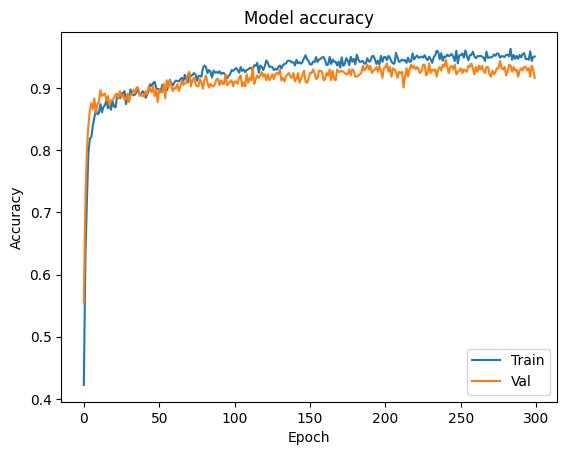

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [20]:
# Define the model
model = Sequential()
adam = Adam(learning_rate=0.01)
model.add(LSTM(units=26, dropout=0.05, recurrent_dropout=0.25, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(units=64, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(units=128,  dropout=0.05, recurrent_dropout=0.25, return_sequences=True))
model.add(LSTM(units=64,  dropout=0.05, recurrent_dropout=0.25, return_sequences=True))
model.add(LSTM(units=128,  dropout=0.05, recurrent_dropout=0.25, return_sequences=True))
model.add(Flatten())
model.add(Dense(units=12, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"],)
model.summary()

# Define a callback to save the best model
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=300, batch_size=32, callbacks=[checkpoint])

# Predict on test data
y_pred = model.predict(X_reshaped)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 1, 26)          │         5,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 1, 64)          │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,396 (1.06 MB)

 Trainable params: 277,396 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
63/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3213 - loss: 1.9546
Epoch 1: val_loss improved from inf to 1.48965, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3248 - loss: 1.9411 - val_accuracy: 0.4718 - val_loss: 1.4897
Epoch 2/300
60/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5624 - loss: 1.2300
Epoch 2: val_loss improved from 1.48965 to 0.96033, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5650 - loss: 1.2204 - val_accuracy: 0.7146 - val_loss: 0.9603
Epoch 3/300
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6997 - loss: 0.9178
Epoch 3: val_loss improved from 0.96033 to 0.82230, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7002 - loss: 0.9163 - val_accuracy: 0.7670 - val_loss: 0.8223
Epoch 4/300
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7893 - loss: 0.6800
Epoch 4: val_loss improved from 0.82230 to 0.63874, saving mode

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Predict on test data
y_pred = model.predict(X_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y.flatten(), y_pred_classes.flatten()))

 1/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.67      0.78        57
           1       0.72      1.00      0.84        13
           2       0.94      0.91      0.93        55
           3       0.99      0.95      0.97       299
           4       0.99      0.99      0.99       371
           5       1.00      1.00      1.00       801
           6       0.92      0.77      0.84        31
           7       0.90      0.96      0.93       195
           8       0.97      0.99      0.98       342
           9       0.96      0.99      0.98       404
          10       1.00      0.86      0.92         7

    accuracy                           0.97      2575
   macro avg       0.94      0.92      0.92      2575
weighted avg       0.97      0.97      0.97      2575



In [22]:
print(accuracy_score(y.flatten(), y_pred_classes.flatten()))

0.9739805825242719


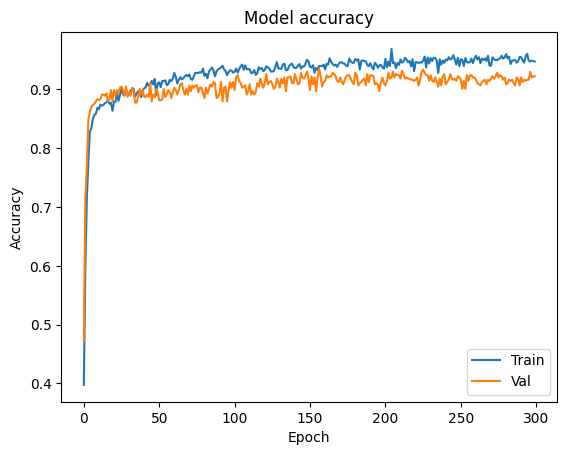

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()